In [1]:
import nilearn.image as ni
import nibabel as nb
from nilearn.plotting import plot_anat, plot_prob_atlas, show, plot_stat_map
import SimpleITK as sitk
from utils import pad_nifti_image, multires_registration, interpolate_zeros
from aligner import Aligner
from warp_utils import apply_warp
import numpy as np
from monai.transforms import LoadImage, EnsureChannelFirst
from warper import Warper



# %matplotlib notebook
# import gui


In [2]:
#subbase = "/deneb_disk/RodentTools/data/test4/29408.native"#
subbase="/home/ajoshi/Downloads/rejacobiandetmaps/sub-28M2BC_T2w"

sub_bse_t2 = "/home/ajoshi/Downloads/rejacobiandetmaps/sub-28M2BC_T2w.SwinGUNETR.stripped.nii.gz" #subbase+".bfc.nii.gz"

atlas_bse_t2 = "/home/ajoshi/Downloads/rejacobiandetmaps/MSA50.brain.nii.gz"
atlas_labels = "/home/ajoshi/Downloads/rejacobiandetmaps/MSA50.label.nii.gz"

centered_atlas = subbase+".atlas.cent.nii.gz"
centered_atlas_labels = subbase+".atlas.cent.label.nii.gz"
cent_transform_file = subbase+".cent.reg.tfm"
inv_cent_transform_file = subbase+".cent.reg.inv.tfm"
centered_atlas_linreg = subbase+".atlas.lin.nii.gz"
centered_atlas_linreg_labels = subbase+".atlas.lin.label.nii.gz"
lin_reg_map_file = subbase+".lin_ddf.map.nii.gz"


In [3]:

nonlin_reg_map_file = subbase+".nonlin_ddf.map.nii.gz"
inv_nonlin_reg_map_file = subbase+".inv.nonlin_ddf.map.nii.gz"
centered_atlas_nonlinreg = subbase+".atlas.nonlin.nii.gz"
centered_atlas_nonlinreg_labels = subbase+".atlas.nonlin.label.nii.gz"
jac_det_file = subbase+".jacobian_det.nii.gz"
inv_jac_det_file = subbase+".inv.jacobian_det.nii.gz"

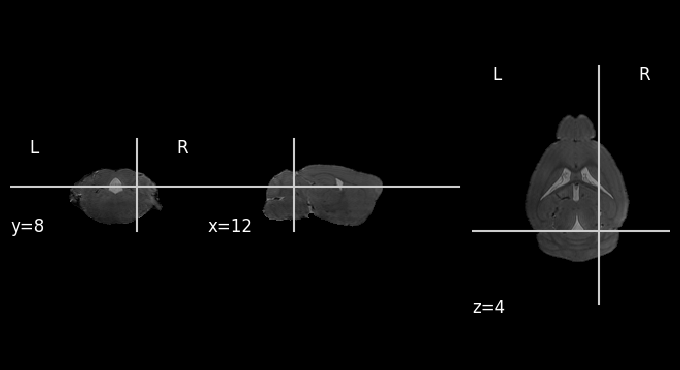

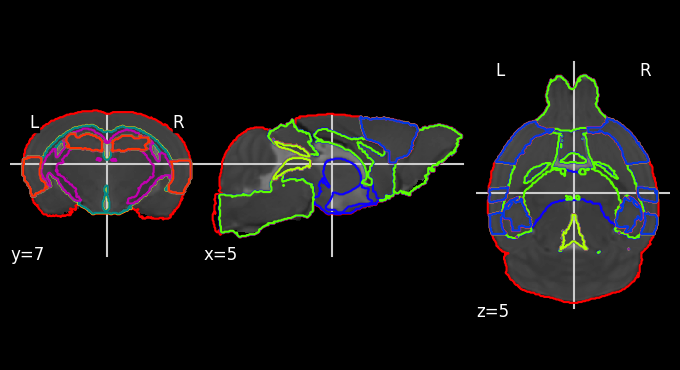

In [4]:

plot_anat(sub_bse_t2)
d = plot_anat(atlas_bse_t2)
d.add_contours(atlas_labels, cmap="prism")


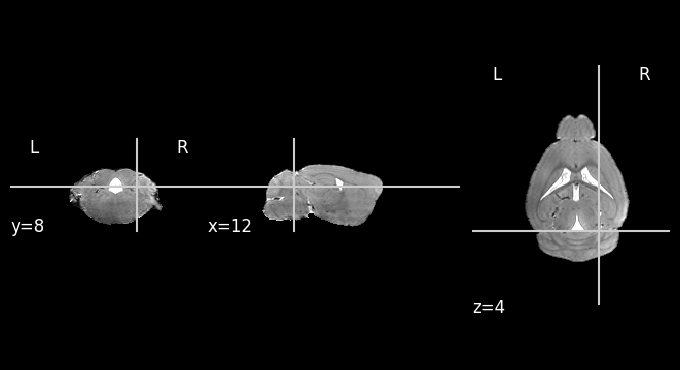

In [5]:
plot_anat(sub_bse_t2, vmax=np.percentile(nb.load(sub_bse_t2).get_fdata(), 99.9),vmin=0)


In [6]:
fixed_image = sitk.ReadImage(sub_bse_t2, sitk.sitkFloat32)
moving_image = sitk.ReadImage(atlas_bse_t2, sitk.sitkFloat32)
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

final_transform, _ = multires_registration(
    fixed_image, moving_image, initial_transform)


# save the transformation in a file
sitk.WriteTransform(final_transform, cent_transform_file)

# invert the transform and also save to a file
inv_transform = final_transform.GetInverse()
sitk.WriteTransform(inv_transform, inv_cent_transform_file)

# load from the file and apply the transformation
final_transform = sitk.ReadTransform(cent_transform_file)
moved_image = sitk.Resample(moving_image, fixed_image, final_transform)

sitk.WriteImage(moved_image, centered_atlas)

moving_image = sitk.ReadImage(atlas_labels, sitk.sitkUInt16)
moved_image = sitk.Resample(
    moving_image,
    fixed_image,
    transform=final_transform,
    interpolator=sitk.sitkNearestNeighbor,
)
sitk.WriteImage(moved_image, centered_atlas_labels)




Final metric value: -0.3484470383491358
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 11.


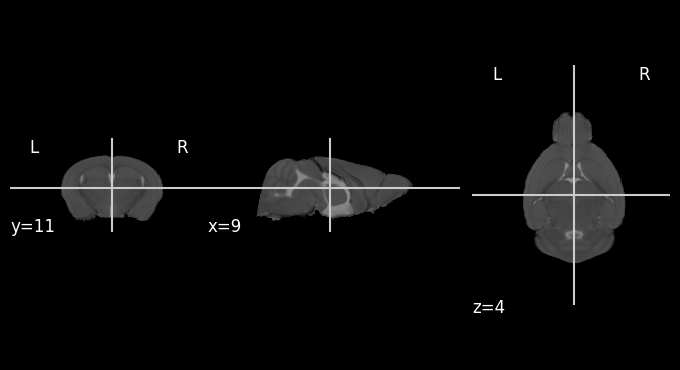

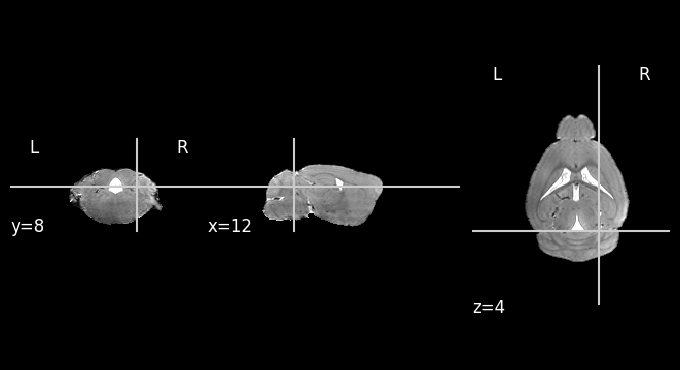

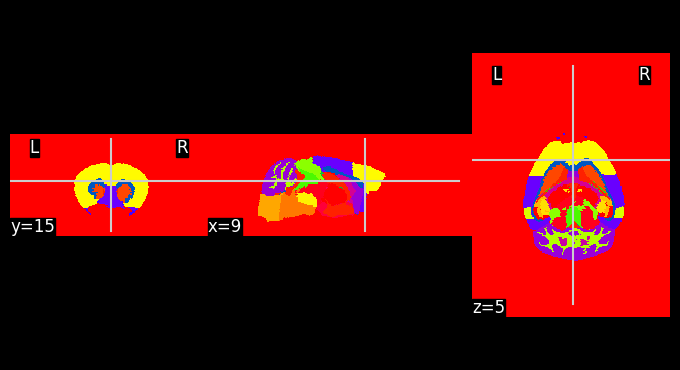

In [7]:

plot_anat(centered_atlas)
plot_anat(sub_bse_t2, vmax = np.percentile(nb.load(sub_bse_t2).get_fdata(), 99.9),vmin=0)
plot_anat(centered_atlas_labels, cmap='prism')

show()

In [8]:
aligner = Aligner()
aligner.affine_reg(
    fixed_file=sub_bse_t2,
    moving_file=centered_atlas,
    output_file=centered_atlas_linreg,
    ddf_file=lin_reg_map_file,
    loss="cc",
)


monai.networks.blocks.Warp: Using PyTorch native grid_sample.


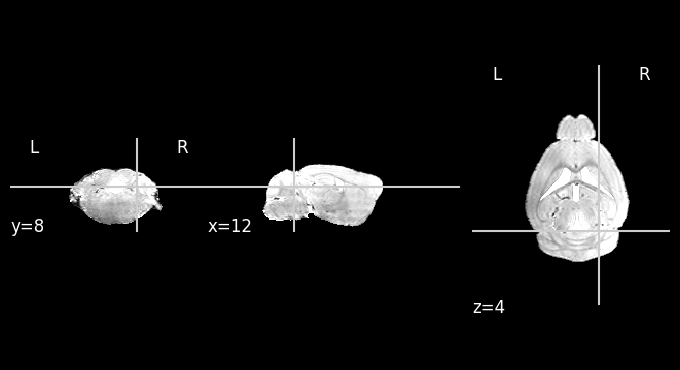

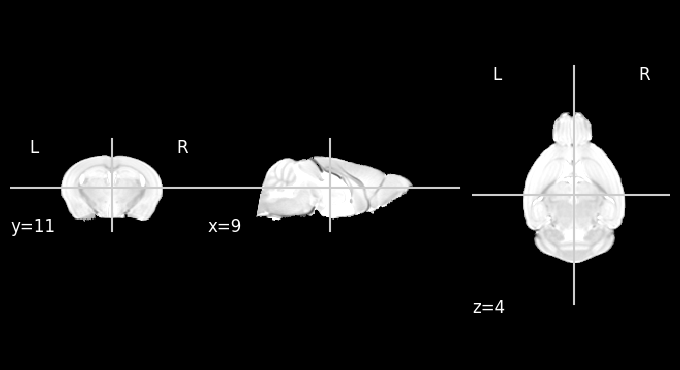

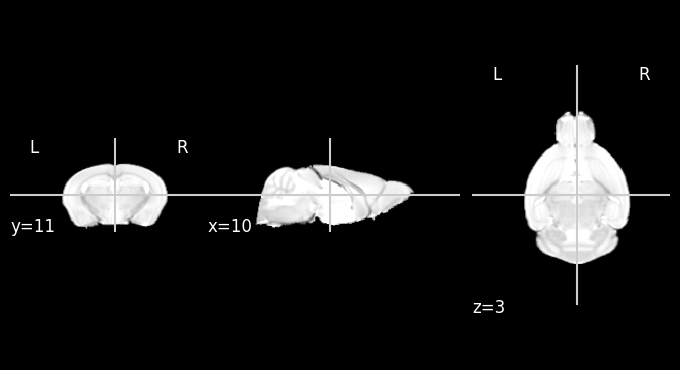

In [9]:

plot_anat(sub_bse_t2, vmax=np.percentile(nb.load(sub_bse_t2).get_fdata(), 99),vmin=0)
plot_anat(centered_atlas, vmax=np.percentile(nb.load(centered_atlas).get_fdata(), 99),vmin=0)
plot_anat(centered_atlas_linreg, vmax=np.percentile(nb.load(centered_atlas_linreg).get_fdata(), 99),vmin=0)


In [10]:
disp_field, meta = LoadImage(image_only=False)(lin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage(image_only=False)(centered_atlas_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(warped_lab[0, 0].detach().cpu().numpy(), at_lab.affine),
    centered_atlas_linreg_labels,
)


torch.Size([3, 192, 256, 100])
torch.Size([1, 192, 256, 100])


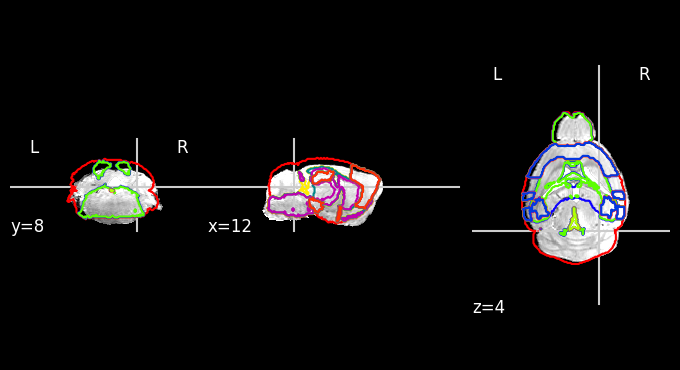

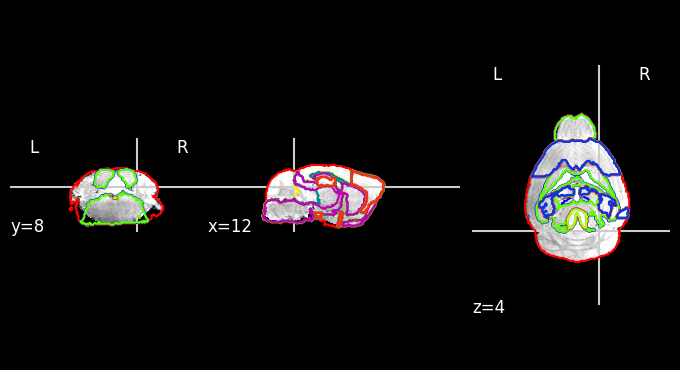

In [11]:
d = plot_anat(sub_bse_t2, vmax=np.percentile(nb.load(sub_bse_t2).get_fdata(), 99),vmin=0)
d.add_contours(centered_atlas_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=np.percentile(nb.load(sub_bse_t2).get_fdata(), 99),vmin=0)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")


In [12]:
nonlin_reg = Warper()
nonlin_reg.nonlinear_reg(
    target_file=sub_bse_t2,
    moving_file=centered_atlas_linreg,
    output_file=centered_atlas_nonlinreg,
    ddf_file=nonlin_reg_map_file,
    inv_ddf_file=inv_nonlin_reg_map_file,
    reg_penalty=1,
    nn_input_size=64,
    lr=1e-4,
    max_epochs=5000,
    loss="cc",
    jacobian_determinant_file=jac_det_file,
    inv_jacobian_determinant_file=inv_jac_det_file,
)


optimizing
finished  5000  epochs93m -0.16  



computing deformation field
computing inverse deformation field
applying warp
saving warped output: /home/ajoshi/Downloads/rejacobiandetmaps/sub-28M2BC_T2w.atlas.nonlin.nii.gz
saving ddf: /home/ajoshi/Downloads/rejacobiandetmaps/sub-28M2BC_T2w.nonlin_ddf.map.nii.gz
saving inv_ddf: /home/ajoshi/Downloads/rejacobiandetmaps/sub-28M2BC_T2w.inv.nonlin_ddf.map.nii.gz


In [13]:
disp_field, meta = LoadImage(image_only=False)(nonlin_reg_map_file)
disp_field = EnsureChannelFirst()(disp_field)
print(disp_field.shape)

at1, meta = LoadImage(image_only=False)(centered_atlas_linreg_labels)
at_lab = EnsureChannelFirst()(at1)
print(at_lab.shape)

warped_lab = apply_warp(
    disp_field[None,], at_lab[None,], at_lab[None,], interp_mode="nearest"
)
nb.save(
    nb.Nifti1Image(
        np.uint16(warped_lab[0, 0].detach().cpu().numpy()), at_lab.affine),
    centered_atlas_nonlinreg_labels,
)


torch.Size([3, 192, 256, 100])
torch.Size([1, 192, 256, 100])


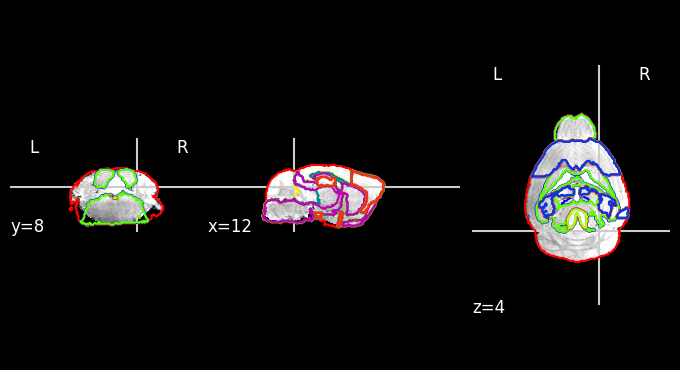

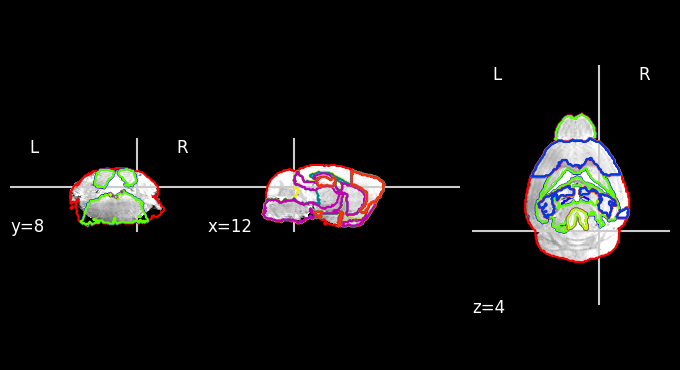

In [14]:
d = plot_anat(sub_bse_t2, vmax=np.percentile(nb.load(sub_bse_t2).get_fdata(), 99),vmin=0)
d.add_contours(centered_atlas_linreg_labels, cmap="prism")
d = plot_anat(sub_bse_t2, vmax=np.percentile(nb.load(sub_bse_t2).get_fdata(), 99),vmin=0)
d.add_contours(centered_atlas_nonlinreg_labels, cmap="prism")


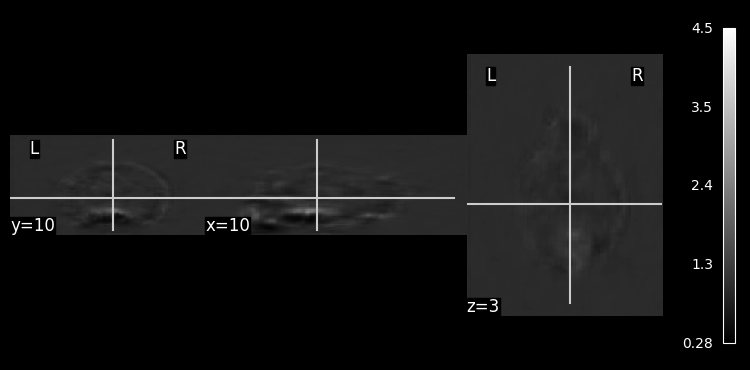

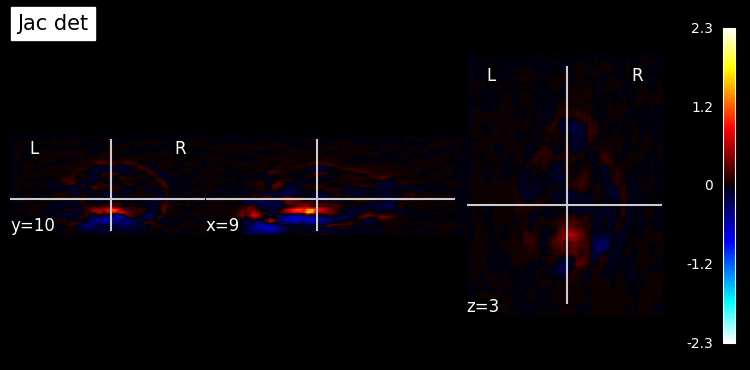

In [15]:
plot_anat(jac_det_file, colorbar=True)

jac=nb.load(jac_det_file)
jac = jac.get_fdata() - 1

from nilearn.image import new_img_like
jac = new_img_like(sub_bse_t2,jac)
plot_stat_map(jac,sub_bse_t2,title='Jac det')

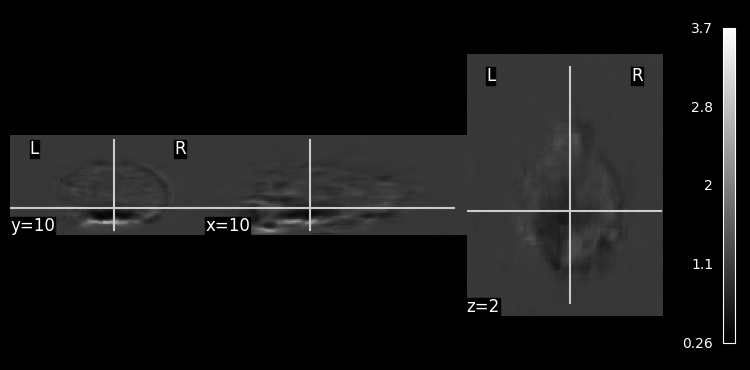

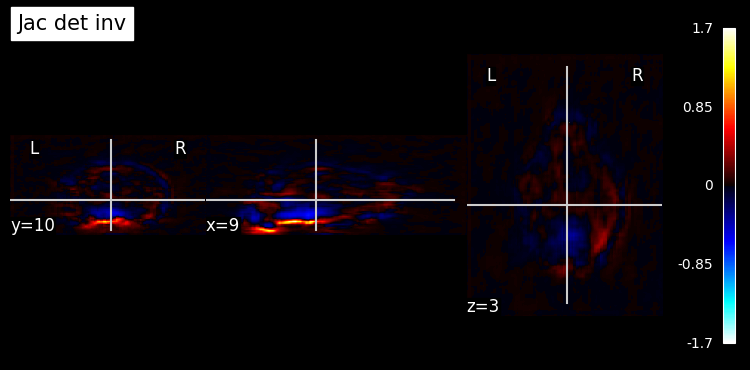

In [16]:
plot_anat(inv_jac_det_file, colorbar=True)

jac=nb.load(inv_jac_det_file)
jac = jac.get_fdata() - 1

from nilearn.image import new_img_like
jac = new_img_like(sub_bse_t2,jac)
plot_stat_map(jac,sub_bse_t2,title='Jac det inv')
